***

# Geothermal Well Test Analysis with Python
### Notebook 1: Introduction and Data Preparation 
#### Irene Wallis and Katie McLean 
#### Software Underground, Transform 2021

***

### Google Colab Setup

If you are using Google Colab to run this notebook, we assume you have already followed the Google Colab setup steps outlined [here](https://github.com/ICWallis/T21-Tutorial-WellTestAnalysis).

Because we are importing data, we need to "mount your Google Drive", which is where we tell this notebook to look for the data files. You will need to mount the Google Drive into each notebook.  

1. Run the cell below if you are in Google Colab. If you are not in Google Colab, running the cell below will just return an error that says "No module named 'google'". If you get a Google Colab error that says "Unrecognised runtime 'geothrm'; defaulting to 'python3' Notebook settings", just ignore it. 

2. Follow the link generated by running this code. That link will ask you to sign in to your google account (use the one where you have saved these tutorial materials in) and to allow this notebook access to your google drive. 

3. Completing step 2 above will generate a code. Copy this code, paste below where it says "Enter your authorization code:", and press ENTER. 

Congratulations, this notebook can now import data!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


***

# 1. Introduction

#### Tutorial overview

In this tutorial, we provide an overview of geothermal wells, well testing in general, and the types of data that are captured during completion testing. We then step though a completion test analysis workflow including:
- Import, formatting and cleaning of pressure, temperature and spinner log (PTS) data and the associated pump data
- Extraction and plotting of selected temperature logs
- Interpolation of injectivity index from pressure and pump flowrate data
- Detection of feed zones through spinner analysis

Completion testing involves the capture of a large volume of data, which can be cumbersome to analyse in Excel. During this tutorial, we demonstrate efficient and agile processing of these data using Python. Working inside the Jupyter Notebook environment also enables us to generate an annotated record of our work that can be easily repeated or audited, which is worthwhile considering the high-value decisions that are based on completion test analysis. [Jupyter Lab](https://jupyterlab.readthedocs.io/en/stable/user/export.html) and [VS Studio Code](https://code.visualstudio.com/docs/python/jupyter-support) both enable exporting these Jupyter Notebooks to formats more typically used for reports, such as HTML or pdf. 

#### Reuse of the material in this tutorial

We have made this workflow open-source under the Apache 2.0 licence, which is a permissive licence that allows reuse in your own work with attribution to the original authors. If you alter the code or text, then you need to add a prominent notification that indicates where you have made changes.

This code, markdown text, and sample dataset can be cited using the following details:

_Wallis, I.C. and McLean, K. (2021) Geothermal Well Test Analysis with Python, Software Underground Transform 2021 Tutorial, https://github.com/ICWallis/T21-Tutorial-WellTestAnalysis_

***

## 1.1 A definition for geothermal

In this tutorial, we discuss ‘conventional’ geothermal systems where a localised heat source (e.g., shallow crustal magma) or high background heat flow produces a plume of heated fluid that rises buoyantly towards the surface. The hot fluids that are close enough to the surface to be intersected by drilling (a few km) are the conventional geothermal reservoir (Figure 1). At a large scale, we think of these geothermal systems as convection cells that are recharged by regional groundwater. However, their geometry at the reservoir-scale more resembles a thermal conveyor belt where hot fluids are transported by buoyancy process from depth to the near subsurface: They enter the reservoir through one or more deep upflow zones and then exit though one or more shallow outflow zones. We do not discuss engineered (hot dry rock) geothermal systems or low-temperature sedimentary aquifers. However, the testing methods used in those settings are similar to those described in this tutorial. 

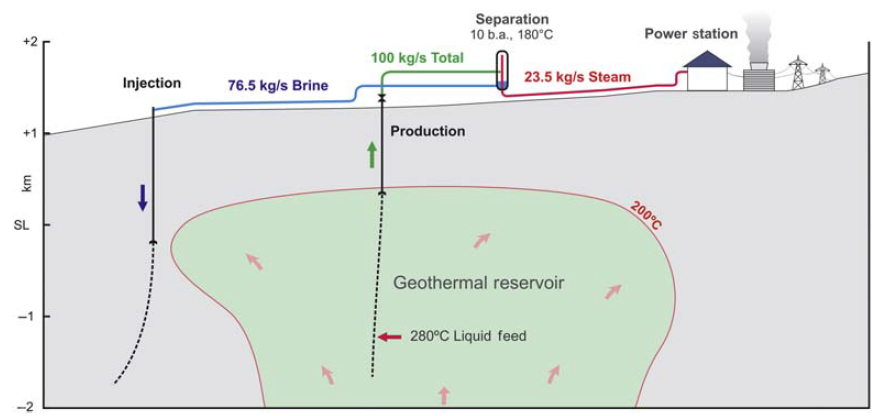

In [1]:
from IPython.display import Image
Image('https://raw.githubusercontent.com/ICWallis/T21-Tutorial-WellTestAnalysis/main/Figures/Figure1.png',width = 800,)

_Figure 1: Cross-section of conventional geothermal reservoir, showing rising plume of buoyant fluid (from Zarrouk and McLean, 2019 and reproduced from Brian Lovelock, Jacobs Ltd. with kind permission)._

For geothermal reservoir engineering, it is useful to classify conventional geothermal systems by enthalpy because it informs on the dominant heat transfer mechanism at work in the reservoir: conduction, convection, or advection (Table 1). 

_Table 1: Classification for geothermal systems by enthalpy (from Kaya et al., 2011)._

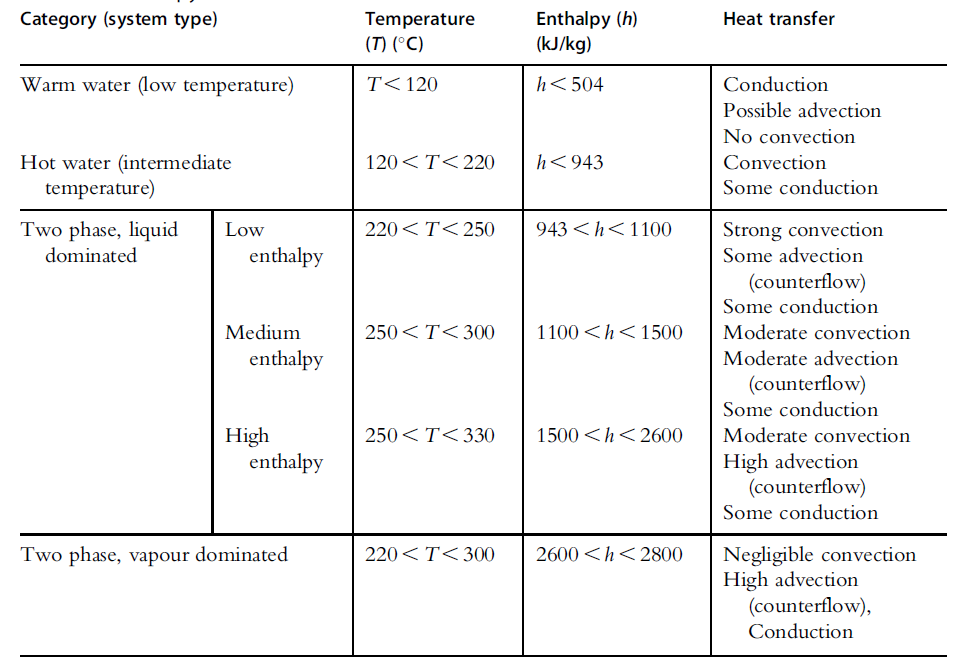

In [2]:
Image('https://raw.githubusercontent.com/ICWallis/T21-Tutorial-WellTestAnalysis/main/Figures/Table1.png',width = 650,)

***

## 1.2 Introduction to geothermal wells

Geothermal wells completions differ significantly from petroleum wells that are  typically only perforated over very short intervals (i.e., have limited access into the reservoir). Geothermal wells have very long perforated intervals with access to the reservoir, often in excess of 1000 metres in length (Figure 2). 

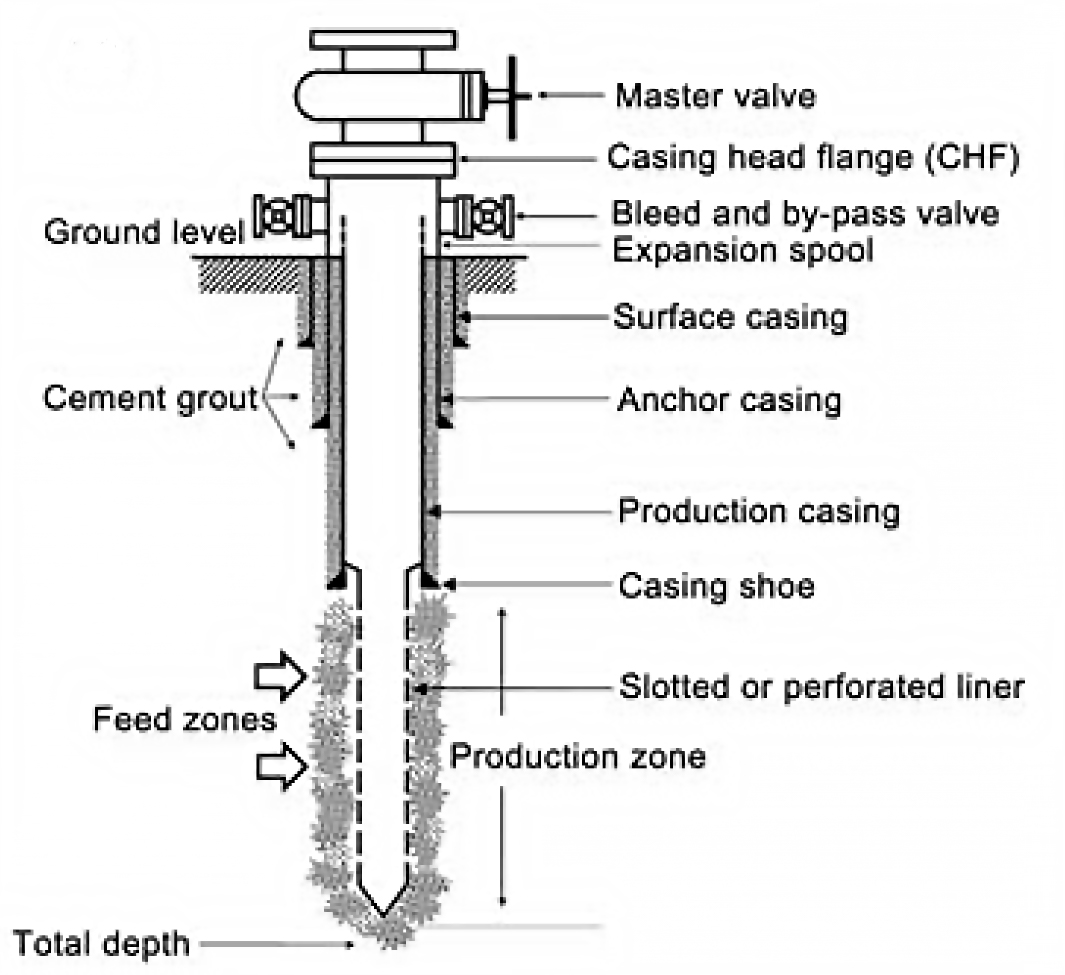

In [3]:
Image('https://raw.githubusercontent.com/ICWallis/T21-Tutorial-WellTestAnalysis/main/Figures/Figure2.jpg',width = 500,)

_Figure 2: Schematic of geothermal well showing feed zones within the production zone accessing the wellbore via the perforated liner (Zarrouk and McLean, 2019)._

Geothermal wells will self-discharge if there is sufficient temperature to generate boiling. In these conditions, flow is driven by the volume expansion of water during boiling rather than high pressures as is the case in groundwater wells. Geothermal wells that are too cool to boil will still flow if there is sufficient hydrostatic head, such as in mountainous areas. Otherwise, these wells are pumped. Pressure gradients in liquid-dominated reservoirs are typically hot hydrostatic (i.e., at a lower pressure than the regional cold hydrostatic gradient). In other words, the pressure is lower inside the reservoir than outside – counter-intuitive but true. 

***

## 1.3 Introduction to well testing

A geothermal well is typically drilled over a period of a few weeks. Immediately after drilling is completed, a program of testing commences. The typical testing sequence is: completion testing, then heating runs, and finally output testing. 

The **completion test** captures pressure, temperature and spinner (PTS) data using a downhole PTS tool (Figure 3). This tool is suspended in the wellbore on a wireline whilst cold water is injected into the well at different rates through the side valve (Figure 4). 

The main objectives of completion testing are to:
1. Identify permeable feed zones in the well, including whether there is a dominant feed zone.
2. Gain an indication of the future potential of the well once in service. 

After completion testing, a set of **heating runs** are conducted in order to observe the pressure and temperature response of the well after cold water injection stops (hence heating commences). Typically at least three heating runs are acquired at increasing time intervals (i.e., immediately after the completion test, then days later, then weeks or months later depending on the reservoir conditions). These heatup data contribute to objectives 1 and 2 of completion testing. 


In [ ]:
Image('https://raw.githubusercontent.com/ICWallis/T21-Tutorial-WellTestAnalysis/main/Figures/Figure3.png',width = 500,)

_Figure 3: Pressure-temperature-spinner (PTS) tool, 2.6 metres in length (Zarrouk and McLean, 2019)._

In [ ]:
Image('https://raw.githubusercontent.com/ICWallis/T21-Tutorial-WellTestAnalysis/main/Figures/Figure4.png',width = 800,)

_Figure 4: Schematic of downhole tool suspended on wireline, including surface equipment setup (Zarrouk and McLean, 2019)._

If the well is destined to be a production well, then it is subjected to output testing (production testing) after heating. Some injection wells are not output tested, if it is certain that they will never be used for production. Typically the well is discharged at multiple flow rates during the output test, while the mass flow and well head pressure recorded for each. From this a single output curve is generated that shows the behaviour/potential of the well under various operating conditions. PTS data are also captured during discharge in order to see which of the feed zones are contributing to the flow, and how much.

If you want to know more about geothermal well testing, check out a book co-authored by Katie with Sadiq Zarrouk that covers the theory and practice of geothermal well test analysis https://www.elsevier.com/books/geothermal-well-test-analysis/zarrouk/978-0-12-814946-1

***

# 2. Import and munge test data

We are working with two sources of data:

1. Pumps operating at the surface (datetime and flow rate)
2. PTS tool in the well (datetime, pressure, temperature, spinner, other tool information)

The following steps take the raw data that has been provided as excel files, imports them as a Pandas dataframe (one called flowrate and the other called pts), and then do some manipulation to generate a nice clean dataset that we can work with.

We will see that data format and data quality are common challenges, especially when datetime is involved. 

In [ ]:
import openpyxl
import pandas as pd
from datetime import datetime

***

## 2.1. Pump (flowrate) data

We will turn the excel data into a Pandas dataframe that includes:
- A datetime field we can use with the tool data
- Flowrate in the units we need

### 2.1.1 Import flowrate data using Pandas

We read the data in with the header location defined as row 1. This automatically skips row 0 which just contains some text that we don’t want.

In [ ]:
# Uncomment (remove the hash symbol) from the method that you want to use

# Use this method if you are running this notebook in Google Colab
flowrate = pd.read_excel(r'/content/drive/My Drive/T21-Tutorial-WellTestAnalysis-main/Data-FlowRate.xlsx', header=1) 

# Use this method if you are running this notebook locally (Anaconda)
#flowrate = pd.read_excel(r'Data-FlowRate.xlsx', header=1) 

### Some useful Pandas methods

We will regularly use a set of Pandas methods to check our data as we munge it


Display the first few rows of the dataframe
    
    df.head() _or_ df.head(n) _to show n rows_

Display the last few rows of the dataframe
    
    df.tail() _or_ df.tail(n) _to show n rows_

Useful information like the dataframe shape and the data types

    df.info() 

A list of the column headers

    df.columns 

Data types in each column

    df.dtypes

Shape of the dataframe
    
    df.shape

### 2.1.2 Rename coloums

We do this to remove spaces from the column headers. 

This step is not compulsory, but the presence of spaces in the column names dictates the code format. Once a column has been created, we can interchangeably use the flowrate.raw_datetime or flowrate\['raw_datetime'\] notation. If there are spaces in the column names, the df.column_name notation will not work and we must use the df\['column_name'\] format.


In [ ]:
flowrate.columns = ['raw_datetime','flow_Lpm'] 

flowrate.head(2)

### 2.1.3 Convert datetime string into Python datetime 

The datetime is in [ISO format](https://en.wikipedia.org/wiki/ISO_8601) and, because it includes the timezone, this is the most globally useful datetime format. 

> 2020-12-11T06:00:00+13:00 

where T indicates the time data and +13:00 is the time shift between UTC and New Zealand where the pumps were recording data. 

In [ ]:
flowrate.info()

Look at the output above and note that the _raw_datetime_ data type is _object_ and not _datetime_

We will use a two-step process to parse this date:

1. Convert it to a datetime object with the default UTC timezone
2. Convert the datetime object to local time in New Zealand so it can be combined with the pts tool data

In [ ]:
# use a method that recognises the ISO format to parse the datetime

list = []
for date in flowrate['raw_datetime']:
    newdate = datetime.fromisoformat(date)
    list.append(newdate)
flowrate['ISO_datetime'] = list

flowrate.tail(2)

The method fromisoformate() is new in version Python 3.7

More information can be found [here](https://docs.python.org/3/library/datetime.html) and [here](https://pythontic.com/datetime/date/fromisoformat)

In [ ]:
flowrate.info()

Now we can see that the data type for the ISO_datetime column is a UTC datetime: datetime64\[ns, UTC+13:00\]

But we need it in local NZ time to combine with the PTS tool data. Luckily, the datetime.strftime method recognises the timezone in the datetime object and does the conversion for us. 

In [ ]:
list = []
for date in flowrate.ISO_datetime:
    newdate = pd.to_datetime(datetime.strftime(date,'%Y-%m-%d %H:%M:%S'))
    list.append(newdate)
flowrate['datetime'] = list

flowrate.head()

In [ ]:
flowrate.info()

Now we have a Python datetime object that we can combine with the PTS data which does not have timezone information.  

### 2.1.4 Add a flowrate field in our desired units

Conversions for typical geothermal flowrate units:

- L/sec to t/hr 3.6
- L/min to t/hr 0.060

In [ ]:
flowrate['flow_tph'] = flowrate.flow_Lpm * 0.060

flowrate.head(2) # 23 to see the non-zero values

### 2.1.5 Trim excess columns from the dataframe

Now we just drop the columns that we don't want from the dataframe

In [ ]:
flowrate.drop(columns = ['raw_datetime', 'flow_Lpm', 'ISO_datetime'], inplace = True)

flowrate.head(2)

### inplace = True

Each time we do something something like drop columns, we generate a new Pandas dataframe. 

The argument inplace=True overwrites the old dataframe with the new one but we could have achieved the same thing with assignment:

    flowrate = flowrate.drop(columns = \['raw_datetime', 'flow_Lpm', 'ISO_datetime'\])

***
## 2.2 Pressure, temperature, spinner tool data

We will use a similar process as above to import and munge the pressure, temperature, and spinner (PTS) tool data. However, the PTS dataset includes an addional challenge generated by bad data.


### 2.1.1 Import pts data using Pandas

In [ ]:
# Use this method if you are running this notebook in Google Colab
pts = pd.read_excel(r'/content/drive/My Drive/T21-Tutorial-WellTestAnalysis-main/Data-PTS.xlsx') 

# Use this method if you are running this notebook locally (Anaconda)
#pts = pd.read_excel(r'Data-PTS.xlsx') 

If you run the cell below, you will see that we have a lot of data in the pts dataframe (101294 rows and 26 columns). 

Efficient handling of large datasets is one of the reasons why Python is better for these kinds of analysis than excel. 

In [ ]:
pts.shape

In [ ]:
pts.head(3)

### 2.2.2 Rename selected column headders

The dataframe has a row of units below the header row that we need to remove. But because we want to know the units of our data, we will rename key columns to remove spaces and include units before dropping the row containing the units.

In [ ]:
# dictionary method for renaming some columns
dict = {
    'DEPTH':'depth_m',
    'SPEED': 'speed_mps',
    'Cable Weight': 'cweight_kg',
    'WHP': 'whp_barg',
    'Temperature': 'temp_degC',
    'Pressure': 'pressure_bara',
    'Frequency': 'frequency_hz'
}

pts.rename(columns=dict, inplace=True)

pts.head(3)

### 2.2.3 Drop units row

Note that we are using the index value to drop the row of units and then we remake the index. Therefore, if we run this cell over and over, it will keep dropping the first row of data. 

If you are unsure what state your dataframe is in or how many times you have run the cell below, it is useful to run the process from the start again (i.e., go back to step _2.1.1 Import pts data using Pandas_ and work down from there). 

In [ ]:
# drop units row using the index value of that row
pts.drop(0, inplace=True)

# re-index the dataframe
pts.reset_index(drop=True, inplace=True)

# WARNING if you run this cell again, it will drop the first line of data

In [ ]:
pts.head(2)

### 2.2.4 Recognise bad datetime data & how to handle excel datetime floats

If you investigate the _Time_ column in our pts dataframe, you'll find that the hours are all set to 00 despite the test running for nearly 12 hours and starting at around 9 in the morning. Unfortunately, these kinds of issues with bad data are common and they are why it's important to QA/QC data when it is acquired. 

We will (reluctantly) use the excel timestamp to generate a new datetime.

An excel timestamp is a floating-point number that reflects the number of days (or part thereof) since a specified start day. There are two systems that start counting from different dates (1900 and 1904) and some fundamental bugs in the way they are implemented. The start date is stored in the excel workbook and we need to know which system is used to correctly generate a datetime. Check out [this documentation](https://openpyxl.readthedocs.io/en/stable/datetime.html) for more information on the challenges of excel timestamps. **The short version is that we should avoid using excel float time whenever possible.** Unfortunately, it is not possible here because of the bad data.

Because we have an xlsx file, will use the openpyxl package to determine the start date in the workbook and parse the excel float to datetime. If you have an xls file, then the xlrd module may be used to achieve the same result.

In [ ]:
# first check the start day system in the workbook

# Use this method if you are in Google Colab
wb = openpyxl.load_workbook(filename=r'/content/drive/My Drive/T21-Tutorial-WellTestAnalysis-main/Data-PTS.xlsx')

# Use this method if you are running the notebook locally in Anaconda
#wb = openpyxl.load_workbook(filename=r'Data-PTS.xlsx')

if wb.epoch == openpyxl.utils.datetime.CALENDAR_WINDOWS_1900: 
    print("This workbook is using the 1900 date system.")
if wb.epoch == openpyxl.utils.datetime.CALENDAR_MAC_1904: 
    print("This workbook is using the 1904 date system.")


We can see in the printed statement above that we have the 1900 date system. Therefore, we can use the default arguments in the from_excel method in the openpyxl utilities. Refer to [the docs](https://openpyxl.readthedocs.io/en/stable/api/openpyxl.utils.datetime.html) for more information.

In [ ]:
list = []
for date in pts.Timestamp:
    newdate = openpyxl.utils.datetime.from_excel(date)
    list.append(newdate)
pts['datetime'] = list

In [ ]:
pts.head(3)

### 2.2.5 Drop unwanted columns from dataframe

There are a lot of columns we do not need for our analysis, so we will drop these


In [ ]:
pts.columns

In [ ]:
pts.drop(columns = ['Date', 'Time', 'Timestamp','Reed 0',
       'Reed 1', 'Reed 2', 'Reed 3', 'Battery Voltage', 
       'PRT Ref Voltage','SGS Voltage', 'Internal Temp 1', 
       'Internal Temp 2', 'Internal Temp 3','Cal Temp', 
       'Error Code 1', 'Error Code 2', 'Error Code 3',
       'Records Saved', 'Bad Pages',], inplace = True)

In [ ]:
pts.head(3)

### 2.2.6 Correct the data types

Run the cell below and note that the data types are 'object'. This is because we had a mix of text and numeric when importing these data (remember the units row). We convert the dtype to numeric using the pd.to_numeric method.

In [ ]:
pts.dtypes

In [ ]:
pts[
    ['depth_m', 'speed_mps','cweight_kg','whp_barg','temp_degC','pressure_bara','frequency_hz']
] = pts[
    ['depth_m','speed_mps','cweight_kg','whp_barg','temp_degC','pressure_bara','frequency_hz']
    ].apply(pd.to_numeric)

pts.dtypes

In [ ]:
pts.columns

Because methods like ipywidget interactive plots only work with floats, we make and append the time in seconds that has elapsed since the start of the test.

In [ ]:
def timedelta_seconds(dataframe_col, test_start):
    '''
    Make a float in seconds since the start of the test

    args:   dataframe_col: dataframe column containing datetime objects
            test_start: test start time formatted '2020-12-11 09:00:00'

    returns: float in seconds since the start of the test
    '''
    test_start_datetime = pd.to_datetime(test_start)
    list = []
    for datetime in dataframe_col:
        time_delta = datetime - test_start_datetime
        seconds = time_delta.total_seconds()
        list.append(seconds)
    return list

test_start_datetime = '2020-12-11 09:26:44.448'

flowrate['timedelta_sec'] = timedelta_seconds(flowrate.datetime, test_start_datetime)
pts['timedelta_sec'] = timedelta_seconds(pts.datetime, test_start_datetime)


***

## We are finished importing and munging the data!

We now have flowrate and pts dataframes that we can work with for the rest of our analysis. 

The steps taken above to import and munge the data are wrapped into custom functions that will be at the top of each notebook.

In the rest of this tutorial, we will call these functions rather than stepping through the method again. 

***

# 3. Overview of the completion test data


In [ ]:
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1,figsize=(18,12),sharex=True)

ax1.plot(flowrate.datetime, flowrate.flow_tph, label='Surface pump flowrate', 
    c='k', linewidth=0.8, marker='.')
ax1.set_ylabel('Surface flowrate [t/hr]')
ax1.set_ylim(0,150)

for ax in [ax2, ax3, ax4]:
    ax.plot(pts.datetime, pts.depth_m, label='PTS tool depth', 
        c='k', linewidth=1.5)
    ax.set_ylabel('PTS tool depth [m]')
    ax.set_ylim(1000,0)

ax4.set_xlabel('Time [hh:mm]')
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
 
injectivity_index = [ # purple
    (pd.to_datetime('2020-12-11 10:28:00'),pd.to_datetime('2020-12-11 10:30:00')),
    (pd.to_datetime('2020-12-11 12:51:00'),pd.to_datetime('2020-12-11 12:53:00')),
    (pd.to_datetime('2020-12-11 15:20:00'),pd.to_datetime('2020-12-11 15:23:00')), # pumps shut off too soon
    ]
injectivity_index_alt = [ # light purple 
    (pd.to_datetime('2020-12-11 14:38:00'),pd.to_datetime('2020-12-11 14:40:00')) # alternate used because of pump issue
    ]
pressure_transient = [ # green
    (pd.to_datetime('2020-12-11 10:36:00'),pd.to_datetime('2020-12-11 12:10:00')),
    (pd.to_datetime('2020-12-11 12:55:15'),pd.to_datetime('2020-12-11 14:40:00')), 
    ]
temperature_profile = [ # red
    (pd.to_datetime('2020-12-11 10:03:00'),pd.to_datetime('2020-12-11 10:11:30')),
    (pd.to_datetime('2020-12-11 12:28:30'),pd.to_datetime('2020-12-11 12:36:00')),
    (pd.to_datetime('2020-12-11 14:57:30'),pd.to_datetime('2020-12-11 15:05:00')),
    (pd.to_datetime('2020-12-11 16:09:00'),pd.to_datetime('2020-12-11 16:15:30'))
    ]
fluid_velocity = [ # yellow
    (pd.to_datetime('2020-12-11 09:46:00'),pd.to_datetime('2020-12-11 10:25:00')),
    (pd.to_datetime('2020-12-11 12:10:30'),pd.to_datetime('2020-12-11 12:51:00')),
    (pd.to_datetime('2020-12-11 14:40:30'),pd.to_datetime('2020-12-11 15:19:00')),
    ]

ax1.set_title('Pressure transient analysis (not included in this tutorial)')
for top, bottom in pressure_transient:
    ax1.axvspan(top, bottom, color='#369a33', alpha=0.3) # green

ax2.set_title('Temperature profile analysis - Notebook 2')
for top, bottom in temperature_profile:
    ax2.axvspan(top, bottom, color='#9a3336', alpha = 0.5) # red 

ax3.set_title('Determine well capacity (injectivity index) - Notebook 3')
for top, bottom in injectivity_index:
    ax3.axvspan(top, bottom, color='#33369a', alpha=.6) # purple

for top, bottom in injectivity_index_alt:
    ax3.axvspan(top, bottom, color='#33369a', alpha=.3) # light purple
    
ax4.set_title('Feed zones from fluid velocity analysis - Notebook 4')
for top, bottom in fluid_velocity:
    ax4.axvspan(top, bottom, color='#ffc000', alpha=.3) # yellow 

for ax in [ax1, ax2, ax3, ax4]:
    ax.grid()
 
plt.show();

#### Overview of the completion test (plot above)

The highlighted areas on the plot above are the data we will extract for analysis during this tutorial. 

The zig-zags in the PTS tool depth show the tool going up and down inside the well. Injectivity index (well capacity) uses pressure and flow rate just after these tool passes are complete and before the pump rate is changed (dark purple). However, after the third set of passes (i.e., during the third flowrate) the pumps were shut off too soon, so we will use the pressure and flow rate just prior to the passes (light purple).

#### Use the plot below to explore the entire dataset

In [ ]:
def overview_fig(pts_df,flowrate_df,title=''):
    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1,figsize=(10,15),sharex=True)
    ax1.set_title(title,y=1.1,fontsize=15)

    ax1.plot(flowrate_df.datetime, flowrate_df.flow_tph, label='Surface pump flowrate', 
        c='k', linewidth=0.8, marker='.')
    ax1.set_ylabel('Surface flowrate [t/hr]')
    ax1.set_ylim(0,150)
    
    ax2.plot(pts_df.datetime, pts_df.depth_m, label='PTS tool depth', 
        c='k', linewidth=0.8)
    ax2.set_ylabel('PTS tool depth [m]')
    ax2.set_ylim(1000,0)
    
    ax3.plot(pts_df.datetime, pts_df.pressure_bara, label='PTS pressure', 
        c='tab:blue', linewidth=0.8)
    ax3.set_ylabel('PTS pressure [bara]')
    
    ax4.plot(pts_df.datetime, pts_df.temp_degC, label='PTS temperature', 
        c='tab:red', linewidth=0.8)
    ax4.set_ylabel('PTS temperature')
    
    ax5.plot(pts_df.datetime, pts_df.frequency_hz, label='PTS impeller frequency', 
        c='tab:green', linewidth=0.8)
    ax5.set_ylim(-30,30)
    ax5.set_ylabel('PTS impeller frequency [hz]')
    # 1 hz = 60 rpm

    ax6.plot(pts_df.datetime, pts_df.speed_mps, label='PTS tool speed', 
        c='tab:orange', linewidth=0.8)
    ax6.set_ylim(-2,2)
    ax6.set_ylabel('PTS tool speed [mps]')
    
    ax6.set_xlabel('Time [hh:mm]')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
        ax.grid()
    
    return plt

In [ ]:
overview_fig(pts,flowrate);

Note that I sometimes use a ; at the end of the code in the cell to suppress extra output, as is has been done above.

***

### Cited references

Kaya, E., Zarrouk, S.J., and O’Sullivan, M.J. (2011): Reinjection in geothermal fields: a review of worldwide experience. Renew. Sustain. Energy Rev. 15 (1), 47-68. 

Zarrouk, S.J. and McLean, K. (2019): Geothermal well test analysis: fundamentals, applications, and advanced techniques. 1st edition, Elsevier. 

***

© 2021 [Irene Wallis](https://www.cubicearth.nz/) and [Katie McLean](https://www.linkedin.com/in/katie-mclean-25994315/) 

Licensed under the Apache License, Version 2.0


***